# Aliasing
-----
##### The reason that strange artifacts appear in sampled signals.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
plt.style.use('seaborn')

To start, we will use numpy, matplotlib, and scipy to get a visual idea of the concepts we're discussing.

In [4]:
# number of samples and analog wave frequency
f_sin = 500
N = 10000
fs = 4000

We can then design our test signal to be a sin wave with a frequency of 500 hz, and set parameters saying we will sample that signal 10000 times at a frequency of 4000 hz.

**Note** We are taking many samples (10000) to reduce the effects of windowing and spectral leakage, which will be discussed as a future DSP topic.

In [5]:
def getSamplesAndFFT(N, fs, f_sin):
    # create wave samples from parameters
    x = np.linspace(0, N / fs, N - 1)
    y = np.sin(f_sin * 2 * np.pi * x)

    # fft of sampled sin wave
    xf = np.linspace(- fs / 2, fs / 2, N - 1)
    yf = scipy.fftpack.fft(y)
    yf = [w / fs for w in yf]   # account for sampling scaling
    yf = scipy.fftpack.fftshift(yf)
    return [x, y, xf, yf]

[x, y, xf, yf] = getSamplesAndFFT(N, fs, f_sin)

We can use these parameters to get the sampled values, as well as the FFT computed from those sampled values. This is done using the `getSamplesAndFFT` function shown above.

When a signal is sampled, its FFT is scaled up by the sampling frequency, so we divide each entry in `yf` by `fs` to determine the frequency magnitude we would expect from the original signal.

We also use the `fftshift` method to show both the negative and positive frequency components calculated from the FFT. Because this is a real-valued signal, we expect the FFT results to be conjugate symmetric.

In [6]:
def samplePlot(axis, x, y, fs, f_sin):
    # display first three periods of original signal
    fs_ideal = 10000
    n_display = int(fs_ideal / f_sin * 3)
    x_ideal = np.linspace(0, n_display / fs_ideal, n_display)
    y_ideal = np.sin(f_sin * 2 * np.pi * x_ideal)
    axis.plot(x_ideal, y_ideal)

    # display samples taken from three periods of signal
    n_display = int(3 * fs / f_sin)
    axis.plot(x[:n_display + 1], y[:n_display + 1], 'ro')
    axis.set(xlabel='Time (sec)', ylabel='Amplitude')
    
def fftPlot(real_axis, angle_axis, xf, yf, fs):
    real_axis.plot(xf, np.absolute(yf))
    real_axis.set(xlabel='Frequency (Hz)', ylabel='Magnitude')
    angle_axis.plot(xf, np.angle(yf))
    angle_axis.set(xlabel='Frequency (Hz)', ylabel='Angle')

Now that we have the signal samples and the FFT of those signal samples, we can write some utility functions that will help us create plots of them.

First, we will plot the original signal with the sampled values highlighted. This is done using the `samplePlot` function. Second, we will plot the FFT computed with the sampled points using the `fftPlot` function.

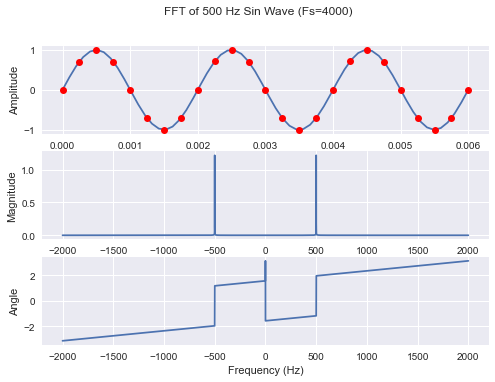

In [7]:
# plot oversampled sin wave and fft results
fig, axs = plt.subplots(3, 1)
fig.suptitle('FFT of ' + str(f_sin) + ' Hz Sin Wave (Fs=' + str(fs) + ')')
samplePlot(axs[0], x, y, fs, f_sin)
fftPlot(axs[1], axs[2], xf, yf, fs)
plt.show()

We now have our original signal and the points at which it was sampled. Below it we also have the FFT of the sampled points, which accurately shows peaks at the -500 and 500 hz frequencies (and is also conjugate symmetric).

**Because we sampled above the Nyquist frequency of 1000 hz, we accurately determined the frequency components of the signal.**

Let's now repeat the entire process, but sample the test signal at *less than* the Nyquist frequency.

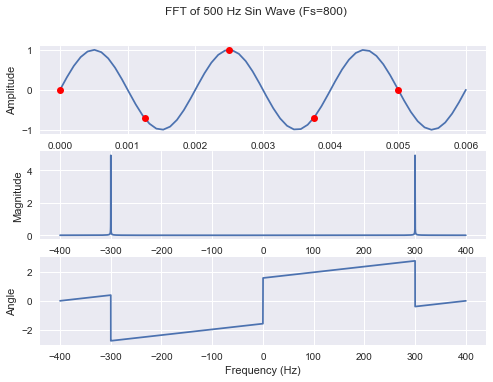

In [8]:
# undersampling 500 hz sin wave at 800 hz
fs2 = 800
[x1, y1, xf1, yf1] = getSamplesAndFFT(N, fs2, f_sin)

# plot undersampled sin wave and fft results
fig2, axs2 = plt.subplots(3, 1)
fig2.suptitle('FFT of ' + str(f_sin) + ' Hz Sin Wave (Fs=' + str(fs2) + ')')
samplePlot(axs2[0], x1, y1, fs2, f_sin)
fftPlot(axs2[1], axs2[2], xf1, yf1, fs2)
plt.show()

**Uh oh.** We now have an example of aliasing. Because the samples were taken much less frequently, a sin wave with a frequency of 300 hz now fits the sampled points. This is in contrast to the original test signal, which had a frequency of 500 hz.

Now that we have seen that sampling gives us unexpected FFT results, we can solidify our understanding with one final visual.

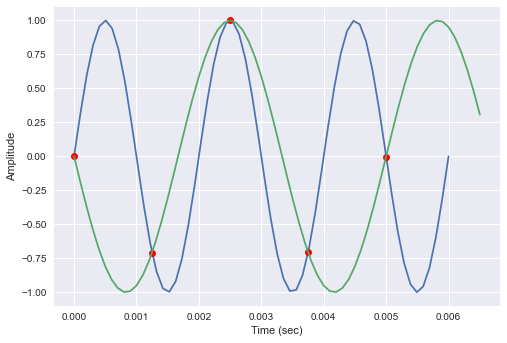

In [9]:
# plot the 500 hz signal sampled at 800 hz (same as earlier)
figure, axis = plt.subplots()
samplePlot(axis, x1, y1, fs2, f_sin)

# superimpose the 300 hz wave
f_sin_300 = 300
fs_ideal = 10000
x = np.linspace(0, N / fs_ideal, N - 1)
y = np.sin(f_sin_300 * 2 * np.pi * x - np.pi)
y = [w * 1 for w in y]
t = int(2 * fs_ideal / f_sin_300)
axis.plot(x[:t], y[:t])
plt.show()

The sampled points are intersected by both the original 500 hz sin wave and the 300 hz aliased frequency. Notice that the 300 hz wave has a phase shift of $\pi$ radians to correctly intersect the sampled points, but nonetheless is an alias of the 500 hz signal.

The aliasing effect is the reason that ADCs must be fast. To work on a project with a high frequency component, you most often have to sample at twice that highest frequency. However, in applications where you are working within a known bandwidth, you can use a lower sampling rate and interpret the true signal at lower, aliased frequencies.